This notebook tunes a the pretrained ResNet-18 for classifying the camera angle F1 cars are viewed from.

This block loads in the necessary packages

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

This block loads in training data

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5, 0.5, 0.5))
])

class ImageFolderWithPaths(ImageFolder):
    # Custom dataset that extends ImageFolder to include image file paths, helps evaluate testing results
    def __getitem__(self, index):
        # Get original tuple: (image, label)
        image, label = super().__getitem__(index)
        # Get image file path
        path = self.imgs[index][0]
        # Return image, label, and path
        return image, label, path

# Set your paths
data_dir = 'C:/Users/fires/Downloads/BalancedData'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = ImageFolderWithPaths(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names to verify 
print("Classes:", train_dataset.classes)
print(len(train_dataset), "training samples loaded")

Classes: ['distantORnocar', 'front', 'inside', 'rear', 'side']
7175 training samples loaded


Load in pretrained model and allow for modification of all weights

In [ ]:
# Load ResNet-18 pretrained on ImageNet
model = models.resnet18(pretrained=True)

# unfreeze all weights
for param in model.parameters():
    param.requires_grad = True

# Replace the final classification layer with 5 categories
num_classes = 5  
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# Unfreeze the classifier head
for param in model.fc.parameters():
    param.requires_grad = True

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


c:\Users\fires\miniconda3\envs\ds-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fires\miniconda3\envs\ds-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model training, includes Adam Optimizer and early stopping as well as validation set metrics

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)  # regularization

# Scheduler: reduce LR if val loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping config
early_stop_patience = 10
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0

# Metrics storage
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 100  # Set high, early stopping will halt before this if needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.4f}")

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping
    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break


Epoch 1: Train Loss=0.6415, Train Acc=0.7787, Val Loss=1.2705, Val Acc=0.6930
Epoch 2: Train Loss=0.3576, Train Acc=0.8937, Val Loss=0.7003, Val Acc=0.7903
Epoch 3: Train Loss=0.2207, Train Acc=0.9307, Val Loss=0.7691, Val Acc=0.7903
Epoch 4: Train Loss=0.1360, Train Acc=0.9586, Val Loss=0.9956, Val Acc=0.7766
Epoch 5: Train Loss=0.1300, Train Acc=0.9645, Val Loss=0.7316, Val Acc=0.8328
Epoch 6: Train Loss=0.0834, Train Acc=0.9752, Val Loss=1.1321, Val Acc=0.7994
Epoch 7: Train Loss=0.0403, Train Acc=0.9880, Val Loss=0.9846, Val Acc=0.8146
Epoch 8: Train Loss=0.0165, Train Acc=0.9965, Val Loss=1.0761, Val Acc=0.8450
Epoch 9: Train Loss=0.0168, Train Acc=0.9960, Val Loss=1.1293, Val Acc=0.8040
Epoch 10: Train Loss=0.0163, Train Acc=0.9948, Val Loss=1.0911, Val Acc=0.8191
Epoch 11: Train Loss=0.0060, Train Acc=0.9986, Val Loss=0.9970, Val Acc=0.8511
Epoch 12: Train Loss=0.0182, Train Acc=0.9947, Val Loss=1.0369, Val Acc=0.8283

Early stopping triggered at epoch 12


Save the model weights to be used in other programs

In [21]:
torch.save(model.state_dict(), 'pretrained_model_weights.pth')

Confusion matrix

In [ ]:
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(test_loader, label_map):
    """
    Evaluate a PyTorch model on a test set and plot the confusion matrix.
    Also print accuracy by category.

    Args:
        test_loader (DataLoader): DataLoader for the test set.
        label_map (dict): Dictionary mapping class names to label indices.
    """
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Create reverse label map: index → class name
    idx_to_class = {v: k for k, v in label_map.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Accuracy by category
    df = pd.DataFrame({"true": all_labels, "pred": all_preds})
    df["correct"] = df["true"] == df["pred"]
    df["true_label"] = df["true"].map(idx_to_class)

    print("\nAccuracy by category:")
    print(df.groupby("true_label")["correct"].mean())


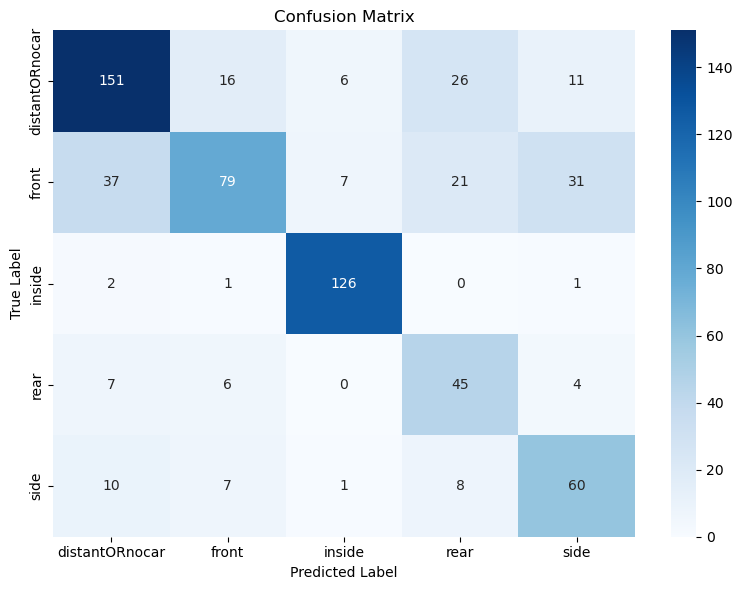


Accuracy by category:
true_label
distantORnocar    0.719048
front             0.451429
inside            0.969231
rear              0.725806
side              0.697674
Name: correct, dtype: float64


In [11]:
label_map = test_dataset.class_to_idx
plot_confusion_matrix(test_loader, label_map)